# **Estratificacion del dengue en el departamento del Cauca, Colombia**

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

plt.style.use('ggplot')


## **Datos meteorológicos**

In [2]:

df_entomologico = pd.read_csv('../data/entomologico.csv')
df_cases = pd.read_csv('../data/cases.csv')

df_meteorologico_patia = pd.read_csv('../data/meteorologicos-patia.csv')
df_meteorologico_miranda = pd.read_csv('../data/meteorologicos-miranda.csv')
df_meteorologico_piamonte = pd.read_csv('../data/meteorologicos-piamonte.csv')

def read_as_df(file_name):
    # Read file
    ds = xr.open_dataset(file_name)
    # Convert to dataframe
    df = ds.to_dataframe()

    # Unstack index (coorfinates)
    ## Get position of the coorfinates in index
    coordinates = ['lat', 'lon']
    ## For each coordinate, reset index:
    for coordinate in coordinates:
        position_index = df.index.names.index(coordinate)
        #print(position_index)
        df = df.reset_index(position_index)
    
    return df

df_humedad_relativa = read_as_df("../data/humedad-relativa.nc").reset_index()
df_precipitacion = read_as_df("../data/precipitacion.nc").reset_index()
df_temp_max = read_as_df("../data/temp-maxima.nc").reset_index()
df_temp_min = read_as_df("../data/temp-minima.nc").reset_index()

### **Limpieza de datos**

In [3]:
# data cleaning: cambio de comas por puntos en los valores numericos de las columnas

df_meteorologico_patia['Temperatura media (°C)'] = df_meteorologico_patia['Temperatura media (°C)'].str.replace(',', '.')
df_meteorologico_patia['Temperatura máxima (°C)'] = df_meteorologico_patia['Temperatura máxima (°C)'].str.replace(',', '.')
df_meteorologico_patia['Temperatura mínima (°C)'] = df_meteorologico_patia['Temperatura mínima (°C)'].str.replace(',', '.')
df_meteorologico_patia['Humedad (%)'] = df_meteorologico_patia['Humedad (%)'].str.replace(',', '.')
df_meteorologico_patia['Precipitación (mm)'] = df_meteorologico_patia['Precipitación (mm)'].str.replace(',', '.')
df_meteorologico_patia['Índice de calor (°C)'] = df_meteorologico_patia['Índice de calor (°C)'].str.replace(',', '.')
df_meteorologico_patia['Fecha'] = pd.to_datetime(df_meteorologico_piamonte['Fecha'], dayfirst=True)

df_meteorologico_piamonte['Temperatura media (°C)'] = df_meteorologico_piamonte['Temperatura media (°C)'].str.replace(',', '.')
df_meteorologico_piamonte['Temperatura máxima (°C)'] = df_meteorologico_piamonte['Temperatura máxima (°C)'].str.replace(',', '.')
df_meteorologico_piamonte['Temperatura mínima (°C)'] = df_meteorologico_piamonte['Temperatura mínima (°C)'].str.replace(',', '.')
df_meteorologico_piamonte['Humedad (%)'] = df_meteorologico_piamonte['Humedad (%)'].str.replace(',', '.')
df_meteorologico_piamonte['Precipitación (mm)'] = df_meteorologico_piamonte['Precipitación (mm)'].str.replace(',', '.')
df_meteorologico_piamonte['Índice de calor (°C)'] = df_meteorologico_piamonte['Índice de calor (°C)'].str.replace(',', '.')
df_meteorologico_piamonte['Fecha'] = pd.to_datetime(df_meteorologico_piamonte['Fecha'], dayfirst=True)

df_meteorologico_miranda['Temperatura media (°C)'] = df_meteorologico_miranda['Temperatura media (°C)'].str.replace(',', '.')
df_meteorologico_miranda['Temperatura máxima (°C)'] = df_meteorologico_miranda['Temperatura máxima (°C)'].str.replace(',', '.')
df_meteorologico_miranda['Temperatura mínima (°C)'] = df_meteorologico_miranda['Temperatura mínima (°C)'].str.replace(',', '.')
df_meteorologico_miranda['Humedad (%)'] = df_meteorologico_miranda['Humedad (%)'].str.replace(',', '.')
df_meteorologico_miranda['Precipitación (mm)'] = df_meteorologico_miranda['Precipitación (mm)'].str.replace(',', '.')
df_meteorologico_miranda['Índice de calor (°C)'] = df_meteorologico_miranda['Índice de calor (°C)'].str.replace(',', '.')
df_meteorologico_miranda['Fecha'] = pd.to_datetime(df_meteorologico_miranda['Fecha'], format='mixed')

In [4]:

df_meteorologico_patia.dropna(subset=['Fecha'], inplace=True)
df_meteorologico_patia = df_meteorologico_patia.sort_values(by=['Fecha'], ascending=True)
df_meteorologico_patia['Temperatura media (°C)'] = df_meteorologico_patia['Temperatura media (°C)'].astype(float)
df_meteorologico_patia['Temperatura máxima (°C)'] = df_meteorologico_patia['Temperatura máxima (°C)'].astype(float)
df_meteorologico_patia['Temperatura mínima (°C)'] = df_meteorologico_patia['Temperatura mínima (°C)'].astype(float)
df_meteorologico_patia['Humedad (%)'] = df_meteorologico_patia['Humedad (%)'].astype(float)
df_meteorologico_patia['Precipitación (mm)'] = df_meteorologico_patia['Precipitación (mm)'].astype(float)
df_meteorologico_patia['Índice de calor (°C)'] = df_meteorologico_patia['Índice de calor (°C)'].astype(float)

df_meteorologico_piamonte.dropna(subset=['Fecha'], inplace=True)
df_meteorologico_piamonte = df_meteorologico_piamonte.sort_values(by=['Fecha'], ascending=True)
df_meteorologico_piamonte['Temperatura media (°C)'] = df_meteorologico_piamonte['Temperatura media (°C)'].astype(float)
df_meteorologico_piamonte['Temperatura máxima (°C)'] = df_meteorologico_piamonte['Temperatura máxima (°C)'].astype(float)
df_meteorologico_piamonte['Temperatura mínima (°C)'] = df_meteorologico_piamonte['Temperatura mínima (°C)'].astype(float)
df_meteorologico_piamonte['Humedad (%)'] = df_meteorologico_piamonte['Humedad (%)'].astype(float)
df_meteorologico_piamonte['Precipitación (mm)'] = df_meteorologico_piamonte['Precipitación (mm)'].astype(float)
df_meteorologico_piamonte['Índice de calor (°C)'] = df_meteorologico_piamonte['Índice de calor (°C)'].astype(float)

df_meteorologico_miranda.dropna(subset=['Fecha'], inplace=True)
df_meteorologico_miranda = df_meteorologico_miranda.sort_values(by=['Fecha'], ascending=True)
df_meteorologico_miranda['Temperatura media (°C)'] = df_meteorologico_miranda['Temperatura media (°C)'].astype(float)
df_meteorologico_miranda['Temperatura máxima (°C)'] = df_meteorologico_miranda['Temperatura máxima (°C)'].astype(float)
df_meteorologico_miranda['Temperatura mínima (°C)'] = df_meteorologico_miranda['Temperatura mínima (°C)'].astype(float)
df_meteorologico_miranda['Humedad (%)'] = df_meteorologico_miranda['Humedad (%)'].astype(float)
df_meteorologico_miranda['Precipitación (mm)'] = df_meteorologico_miranda['Precipitación (mm)'].astype(float)
df_meteorologico_miranda['Índice de calor (°C)'] = df_meteorologico_miranda['Índice de calor (°C)'].astype(float)

### **Agrupacion de datos por mes**

In [5]:

df_meteorologico_patia_grouped = df_meteorologico_patia.groupby(df_meteorologico_patia['Fecha'].dt.month).agg({
    'Temperatura media (°C)': 'mean',
    'Temperatura máxima (°C)': 'max',
    'Temperatura mínima (°C)': 'min',
    'Humedad (%)': 'mean',
    'Precipitación (mm)': 'mean',
    'Índice de calor (°C)': 'mean'
}).reset_index()

df_meteorologico_piamonte_grouped = df_meteorologico_piamonte.groupby(df_meteorologico_patia['Fecha'].dt.month).agg({
    'Temperatura media (°C)': 'mean',
    'Temperatura máxima (°C)': 'max',
    'Temperatura mínima (°C)': 'min',
    'Humedad (%)': 'mean',
    'Precipitación (mm)': 'mean',
    'Índice de calor (°C)': 'mean'
}).reset_index()

df_meteorologico_miranda_grouped = df_meteorologico_miranda.groupby(df_meteorologico_patia['Fecha'].dt.month).agg({
    'Temperatura media (°C)': 'mean',
    'Temperatura máxima (°C)': 'max',
    'Temperatura mínima (°C)': 'min',
    'Humedad (%)': 'mean',
    'Precipitación (mm)': 'mean',
    'Índice de calor (°C)': 'mean'
}).reset_index()

meses = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',    
    12: 'Diciembre'
}

df_meteorologico_patia_grouped['Fecha'] = df_meteorologico_patia_grouped['Fecha'].map(meses)
df_meteorologico_piamonte_grouped['Fecha'] = df_meteorologico_piamonte_grouped['Fecha'].map(meses)
df_meteorologico_miranda_grouped['Fecha'] = df_meteorologico_miranda_grouped['Fecha'].map(meses)

### **Visualizacion de los datos meteorologicos**

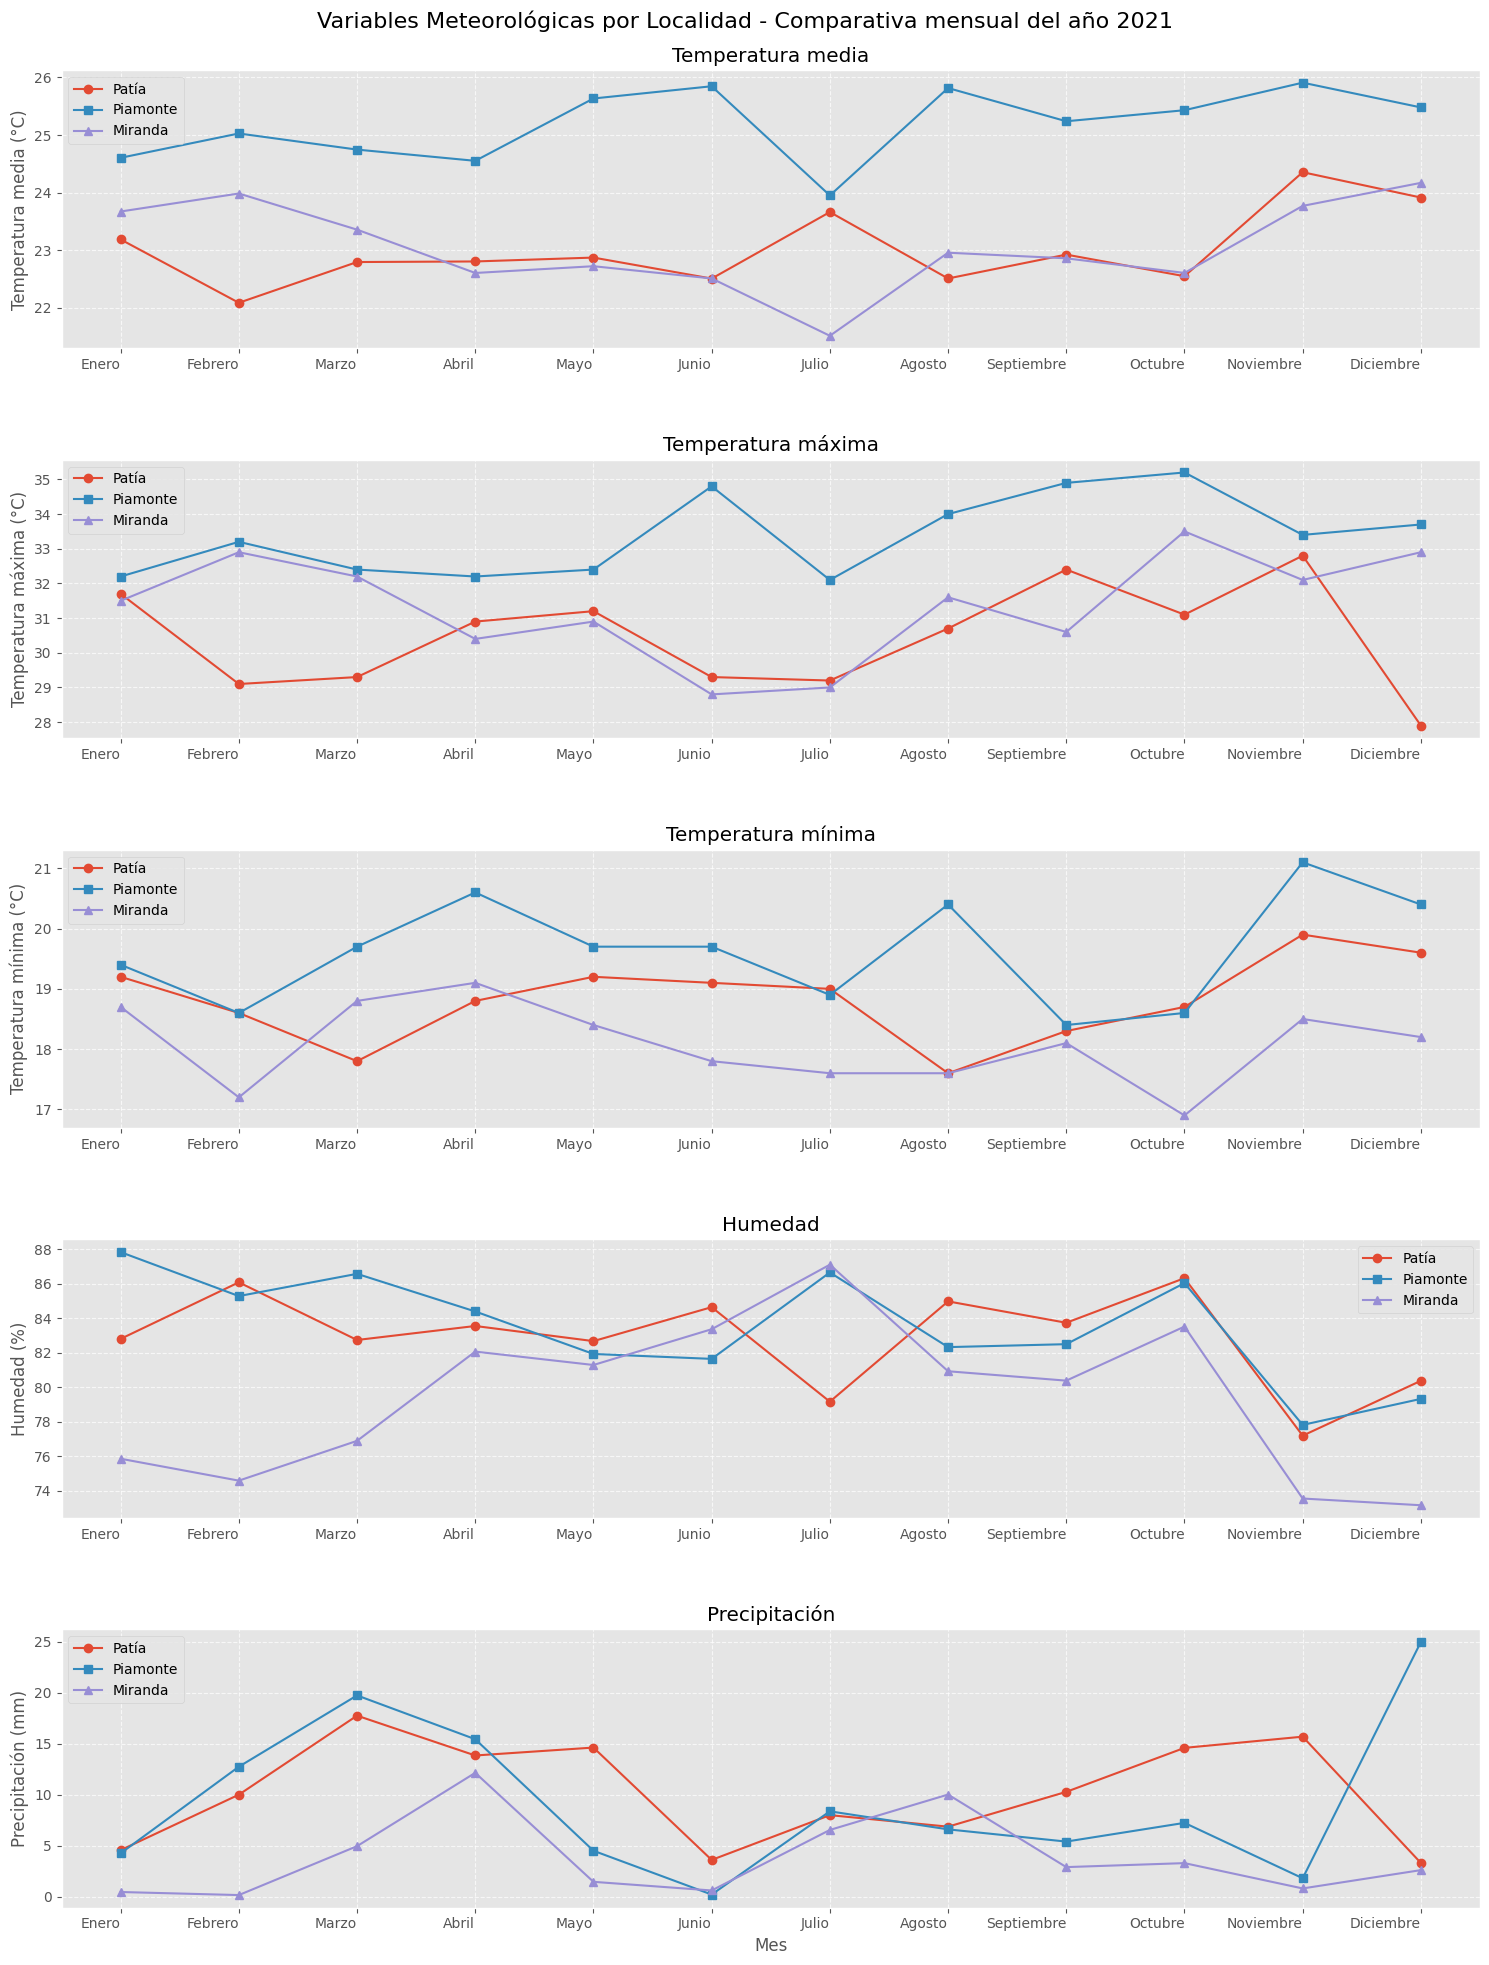

In [6]:
# Create a figure with subplots for each meteorological variable
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=False)

# Common x-axis for all the months to ensure proper ordering
x_order = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# 1. Temperature media
axs[0].plot(df_meteorologico_patia_grouped['Fecha'], df_meteorologico_patia_grouped['Temperatura media (°C)'], marker='o', label='Patía')
axs[0].plot(df_meteorologico_piamonte_grouped['Fecha'], df_meteorologico_piamonte_grouped['Temperatura media (°C)'], marker='s', label='Piamonte')
axs[0].plot(df_meteorologico_miranda_grouped['Fecha'], df_meteorologico_miranda_grouped['Temperatura media (°C)'], marker='^', label='Miranda')
axs[0].set_ylabel('Temperatura media (°C)')
axs[0].set_title('Temperatura media')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend()
axs[0].set_xticks(range(len(x_order)))
axs[0].set_xticklabels(x_order, rotation=0, ha='right')
axs[0].set_xlim(-0.5, len(x_order) - 0.5)

# 2. Temperature maxima
axs[1].plot(df_meteorologico_patia_grouped['Fecha'], df_meteorologico_patia_grouped['Temperatura máxima (°C)'], marker='o', label='Patía')
axs[1].plot(df_meteorologico_piamonte_grouped['Fecha'], df_meteorologico_piamonte_grouped['Temperatura máxima (°C)'], marker='s', label='Piamonte')
axs[1].plot(df_meteorologico_miranda_grouped['Fecha'], df_meteorologico_miranda_grouped['Temperatura máxima (°C)'], marker='^', label='Miranda')
axs[1].set_ylabel('Temperatura máxima (°C)')
axs[1].set_title('Temperatura máxima')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend()
axs[1].set_xticks(range(len(x_order)))
axs[1].set_xticklabels(x_order, rotation=0, ha='right')
axs[1].set_xlim(-0.5, len(x_order) - 0.5)

# 3. Temperature minima
axs[2].plot(df_meteorologico_patia_grouped['Fecha'], df_meteorologico_patia_grouped['Temperatura mínima (°C)'], marker='o', label='Patía')
axs[2].plot(df_meteorologico_piamonte_grouped['Fecha'], df_meteorologico_piamonte_grouped['Temperatura mínima (°C)'], marker='s', label='Piamonte')
axs[2].plot(df_meteorologico_miranda_grouped['Fecha'], df_meteorologico_miranda_grouped['Temperatura mínima (°C)'], marker='^', label='Miranda')
axs[2].set_ylabel('Temperatura mínima (°C)')
axs[2].set_title('Temperatura mínima')
axs[2].grid(True, linestyle='--', alpha=0.7)
axs[2].legend()
axs[2].set_xticks(range(len(x_order)))
axs[2].set_xticklabels(x_order, rotation=0, ha='right')
axs[2].set_xlim(-0.5, len(x_order) - 0.5)

# 4. Humedad
axs[3].plot(df_meteorologico_patia_grouped['Fecha'], df_meteorologico_patia_grouped['Humedad (%)'], marker='o', label='Patía')
axs[3].plot(df_meteorologico_piamonte_grouped['Fecha'], df_meteorologico_piamonte_grouped['Humedad (%)'], marker='s', label='Piamonte')
axs[3].plot(df_meteorologico_miranda_grouped['Fecha'], df_meteorologico_miranda_grouped['Humedad (%)'], marker='^', label='Miranda')
axs[3].set_ylabel('Humedad (%)')
axs[3].set_title('Humedad')
axs[3].grid(True, linestyle='--', alpha=0.7)
axs[3].legend()
axs[3].set_xticks(range(len(x_order)))
axs[3].set_xticklabels(x_order, rotation=0, ha='right')
axs[3].set_xlim(-0.5, len(x_order) - 0.5)

# 5. Precipitación
axs[4].plot(df_meteorologico_patia_grouped['Fecha'], df_meteorologico_patia_grouped['Precipitación (mm)'], marker='o', label='Patía')
axs[4].plot(df_meteorologico_piamonte_grouped['Fecha'], df_meteorologico_piamonte_grouped['Precipitación (mm)'], marker='s', label='Piamonte')
axs[4].plot(df_meteorologico_miranda_grouped['Fecha'], df_meteorologico_miranda_grouped['Precipitación (mm)'], marker='^', label='Miranda')
axs[4].set_ylabel('Precipitación (mm)')
axs[4].set_xlabel('Mes')
axs[4].set_title('Precipitación')
axs[4].grid(True, linestyle='--', alpha=0.7)
axs[4].legend()
axs[4].set_xticks(range(len(x_order)))
axs[4].set_xticklabels(x_order, rotation=0, ha='right')
axs[4].set_xlim(-0.5, len(x_order) - 0.5)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)  # Increased spacing between subplots

# Add an overall title
fig.suptitle('Variables Meteorológicas por Localidad - Comparativa mensual del año 2021', fontsize=16, y=0.98)

plt.show()


## **Datos entomológicos: Diversidad de especies de mosquitos**

In [7]:
df_entomologico['locality'] = df_entomologico['locality'].str.replace(
    r'^Casa ubicada en el barrio (.+) de (.+)$', r'\1 (\2)',
    regex=True
)

df_entomologico['locality'] = df_entomologico['locality'].str.extract(r'^([^(]+)', expand=False).str.strip()
df_entomologico.rename(columns={'locality': 'Barrio'}, inplace=True)
df_entomologico.rename(columns={'county': 'Municipio'}, inplace=True)

df_entomologico['id'] = df_entomologico['id'].str.replace('INS:ProyectoDengue67217:', '', regex=False)

df_entomologico.drop(columns=['organismRemarks', 'eventID','verbatimElevation','higherClassification','genus','subgenus','specificEpithet','vernacularName','eventDate','locationID'], inplace=True)


In [8]:
# split sex column into two columns

# Extract male and female counts from the sex column using regex
df_entomologico['Machos'] = df_entomologico['sex'].str.extract(r'(\d+)\s*[Mm]achos?').fillna(0).astype(int)
df_entomologico['Hembras'] = df_entomologico['sex'].str.extract(r'(\d+)\s*[Hh]embras?').fillna(0).astype(int)

# Verify that rows with just 'Macho' or 'Hembra' (without numbers) are properly handled
macho_only_mask = df_entomologico['sex'].str.match(r'^[Mm]acho$', na=False)
hembra_only_mask = df_entomologico['sex'].str.match(r'^[Hh]embra$', na=False)

df_entomologico.loc[macho_only_mask, 'Machos'] = 1
df_entomologico.loc[hembra_only_mask, 'Hembras'] = 1

df_entomologico.drop(columns=['sex'], inplace=True)

In [17]:
df_entomologico

,id,individualCount,Municipio,Barrio,decimalLatitude,decimalLongitude,scientificName,Machos,Hembras
0,Aed-001,5,Patía,Puerto Nuevo,2.128902,-76.973042,Aedes aegypti,2,3
1,Aed-002,1,Patía,Puerto Nuevo,2.129389,-76.972715,Aedes aegypti,0,1
2,Aed-003,2,Patía,Puerto Nuevo,2.129656,-76.973285,Aedes aegypti,1,1
3,Culx-001,6,Patía,Puerto Nuevo,2.129656,-76.973285,Culex quinquefasciatus,3,3
4,Culx-002,2,Patía,Puerto Nuevo,2.129929,-76.973326,Culex quinquefasciatus,0,2
...,...,...,...,...,...,...,...,...,...
524,Aed-247,8,Miranda,San Antonio,3.248931,-76.231789,Aedes aegypti,4,4
525,Aed-248,1,Miranda,San Antonio,3.248946,-76.231773,Aedes aegypti,1,0
526,Aed-249,20,Miranda,San Antonio,3.248814,-76.231665,Aedes aegypti,15,5
527,Culx-279,1,Miranda,San Antonio,3.248814,-76.231665,Culex quinquefasciatus,0,1


### **Cantidad de ejemplares por especie**

In [9]:
# funciones auxiliares para graficar variables geográficas

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

def group_by_coordinates(df, value_column, sort_ascending=False):
    return df.groupby(['lon', 'lat']).agg({
        value_column: 'mean'
    }).reset_index().sort_values(value_column, ascending=sort_ascending)
    
def plot_geographic_variables(dataframes, value_columns, titles, cmaps=None):
    if cmaps is None:
        cmaps = ['coolwarm'] * len(dataframes)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(dataframes), figsize=(14, 4))
    
    # If only one dataframe is provided, axes will not be an array
    if len(dataframes) == 1:
        axes = [axes]
    
    for i, (df, value_column, title, cmap) in enumerate(zip(dataframes, value_columns, titles, cmaps)):
        # Create geometry points
        geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry=geometry)
        
        # Plot on the corresponding subplot
        gdf.plot(ax=axes[i], column=value_column, cmap=cmap, legend=True,
            legend_kwds={'label': f"Average {value_column.replace('_', ' ').title()}",
                'orientation': "horizontal"})
        
        axes[i].set_title(title)
        axes[i].set_xlabel('Longitud')
        axes[i].set_ylabel('Latitud')
    
    plt.tight_layout()
    return fig, axes

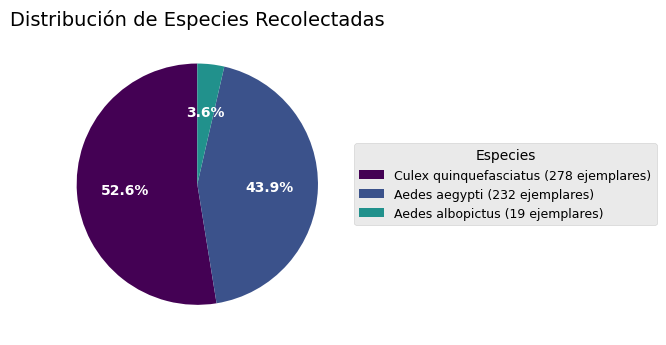

In [10]:
sc = df_entomologico['scientificName'].value_counts()

# Create a smaller figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Define colors
colors = plt.cm.viridis(np.linspace(0, 0.50, len(sc)))

# Create pie chart with white percentage text
wedges, texts, autotexts = ax.pie(
    sc.values, 
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    textprops={'fontsize': 10, 'weight': 'bold', 'color': 'white'},  # Added white color
    startangle=90
)

# Create a legend with species names and counts
legend_labels = [f"{name} ({count} ejemplares)" for name, count in zip(sc.index, sc.values)]
ax.legend(wedges, legend_labels, title="Especies", loc="center left", 
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

plt.title('Distribución de Especies Recolectadas', fontsize=14)
plt.tight_layout()
plt.show()

# Display table with percentages
sc_percent = pd.DataFrame({
    'Cantidad': sc.values,
    'Porcentaje': np.round((sc.values / sc.values.sum()) * 100, 2)
}, index=sc.index).sort_values('Cantidad', ascending=False).reset_index()

In [11]:
import re

# Create the base location_diversity with summary statistics
location_diversity = df_entomologico.groupby(['Barrio', 'Municipio']).agg({
    'individualCount': 'count',
    'scientificName': pd.Series.nunique
}).reset_index().rename(columns={
    'individualCount': 'Total de individuos',
    'scientificName': 'Especies únicas',
})

# Create a pivot table with counts for each species at each location
species_pivot = df_entomologico.pivot_table(
    index=['Barrio', 'Municipio'],
    columns='scientificName', 
    values='individualCount', 
    aggfunc='count',
    fill_value=0
)

# Reset index to prepare for merge
species_pivot = species_pivot.reset_index()

# Merge the two DataFrames
location_diversity = location_diversity.merge(species_pivot, on=['Barrio', 'Municipio'])

location_diversity = location_diversity.sort_values('Total de individuos', ascending=False)

location_diversity_patia = location_diversity[location_diversity['Municipio'] == 'Patía']
location_diversity_piamonte = location_diversity[location_diversity['Municipio'] == 'Piamonte']
location_diversity_miranda = location_diversity[location_diversity['Municipio'] == 'Miranda']

location_diversity_patia = location_diversity_patia.drop(['Especies únicas'], axis=1)
location_diversity_piamonte = location_diversity_piamonte.drop(['Especies únicas'], axis=1)
location_diversity_miranda = location_diversity_miranda.drop(['Especies únicas'], axis=1)

location_diversity = location_diversity.drop(['Especies únicas'], axis=1)

location_diversity

,Barrio,Municipio,Total de individuos,Aedes aegypti,Aedes albopictus,Culex quinquefasciatus
10,Olaya Herrera,Patía,94,45,6,43
16,Villa los Prados,Piamonte,49,7,4,38
5,Fundadores,Piamonte,48,11,0,37
8,La Paz,Piamonte,44,10,1,33
15,San Antonio,Miranda,41,25,1,15
12,Porvenir,Miranda,36,20,0,16
7,La Cabaña,Miranda,32,26,0,6
13,Postobón,Patía,28,4,2,22
11,Popular,Patía,26,10,0,16
9,Libertador,Patía,22,7,1,14


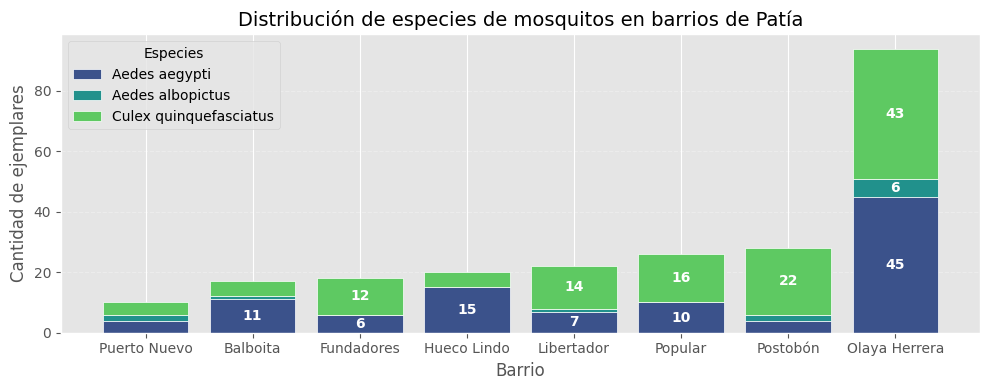

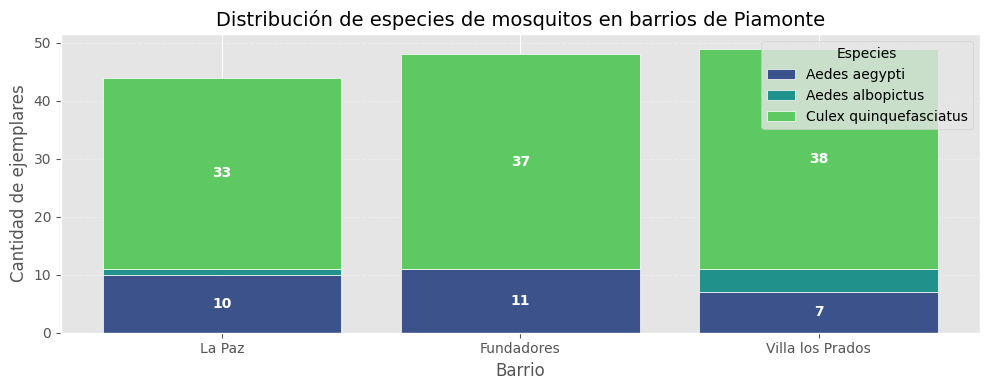

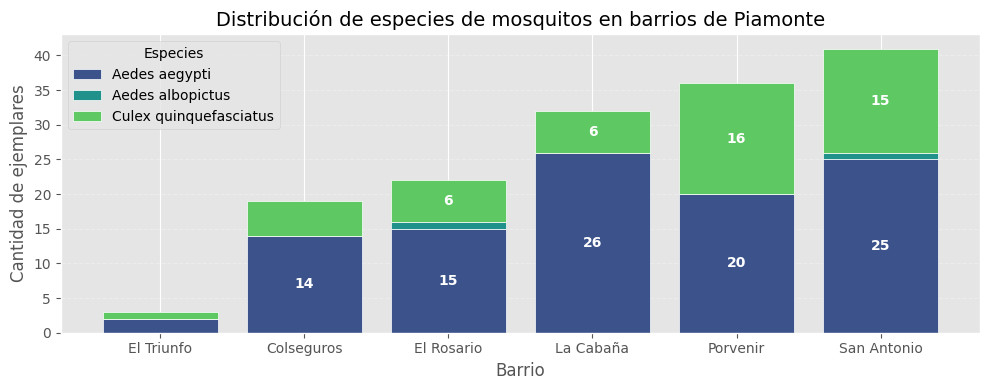

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Sort the data by total number of individuals
location_diversity_patia_sorted = location_diversity_patia.sort_values('Total de individuos', ascending=True)

# Set up the figure with better dimensions for vertical bar chart
plt.figure(figsize=(10, 4))

# Get the species columns (excluding the metadata columns)
species_cols = ['Aedes aegypti', 'Aedes albopictus', 'Culex quinquefasciatus']

# Create a color palette for the species
species_colors = sns.color_palette('viridis', len(species_cols))

# Create the stacked vertical bar chart
bottom = np.zeros(len(location_diversity_patia_sorted))

for i, species in enumerate(species_cols):
    counts = location_diversity_patia_sorted[species].values
    barrios = location_diversity_patia_sorted['Barrio'].values
    
    bars = plt.bar(barrios, counts, bottom=bottom, color=species_colors[i], 
                  label=species, edgecolor='white', linewidth=0.5)
    bottom += counts
    
    # Add count labels on top of the bars
    for j, (count, b) in enumerate(zip(counts, bottom - counts/2)):
        if count > 5:  # Only show label if the count is significant
            plt.text(j, bottom[j] - counts[j]/2, str(int(count)), 
                ha='center', va='center', color='white', fontweight='bold')

# Enhance the chart with proper styling
plt.title('Distribución de especies de mosquitos en barrios de Patía', fontsize=14)
plt.ylabel('Cantidad de ejemplares', fontsize=12)
plt.xlabel('Barrio', fontsize=12)
plt.legend(title='Especies')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Ensure there's no clipping
plt.tight_layout()
plt.show()


# Sort the data by total number of individuals
location_diversity_piamonte_sorted = location_diversity_piamonte.sort_values('Total de individuos', ascending=True)

# Set up the figure with better dimensions for vertical bar chart
plt.figure(figsize=(10, 4))

# Create a color palette for the species
species_colors = sns.color_palette('viridis', len(species_cols))

# Create the stacked vertical bar chart
bottom = np.zeros(len(location_diversity_piamonte_sorted))

for i, species in enumerate(species_cols):
    counts = location_diversity_piamonte_sorted[species].values
    barrios = location_diversity_piamonte_sorted['Barrio'].values
    
    bars = plt.bar(barrios, counts, bottom=bottom, color=species_colors[i], 
        label=species, edgecolor='white', linewidth=0.5)
    bottom += counts
    
    # Add count labels on top of the bars
    for j, (count, b) in enumerate(zip(counts, bottom - counts/2)):
        if count > 5:  # Only show label if the count is significant
            plt.text(j, bottom[j] - counts[j]/2, str(int(count)), 
                ha='center', va='center', color='white', fontweight='bold')

# Enhance the chart with proper styling
plt.title('Distribución de especies de mosquitos en barrios de Piamonte', fontsize=14)
plt.ylabel('Cantidad de ejemplares', fontsize=12)
plt.xlabel('Barrio', fontsize=12)
plt.legend(title='Especies')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Ensure there's no clipping
plt.tight_layout()
plt.show()

# Sort the data by total number of individuals
location_diversity_miranda_sorted = location_diversity_miranda.sort_values('Total de individuos', ascending=True)

# Set up the figure with better dimensions for vertical bar chart
plt.figure(figsize=(10, 4))

# Create a color palette for the species
species_colors = sns.color_palette('viridis', len(species_cols))

# Create the stacked vertical bar chart
bottom = np.zeros(len(location_diversity_miranda_sorted))

for i, species in enumerate(species_cols):
    counts = location_diversity_miranda_sorted[species].values
    barrios = location_diversity_miranda_sorted['Barrio'].values
    
    bars = plt.bar(barrios, counts, bottom=bottom, color=species_colors[i], 
        label=species, edgecolor='white', linewidth=0.5)
    bottom += counts
    
    # Add count labels on top of the bars
    for j, (count, b) in enumerate(zip(counts, bottom - counts/2)):
        if count > 5:  # Only show label if the count is significant
            plt.text(j, bottom[j] - counts[j]/2, str(int(count)), 
                ha='center', va='center', color='white', fontweight='bold')

# Enhance the chart with proper styling
plt.title('Distribución de especies de mosquitos en barrios de Piamonte', fontsize=14)
plt.ylabel('Cantidad de ejemplares', fontsize=12)
plt.xlabel('Barrio', fontsize=12)
plt.legend(title='Especies')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Ensure there's no clipping
plt.tight_layout()
plt.show()

In [13]:
df_cases = df_cases.drop(columns=['OBJECTID', 'Loc_name', 'Match_addr', 'Pertenencia etnica', 'fec_consulta', 'ini_sintomas', 'locationID', 'Ocupación '])

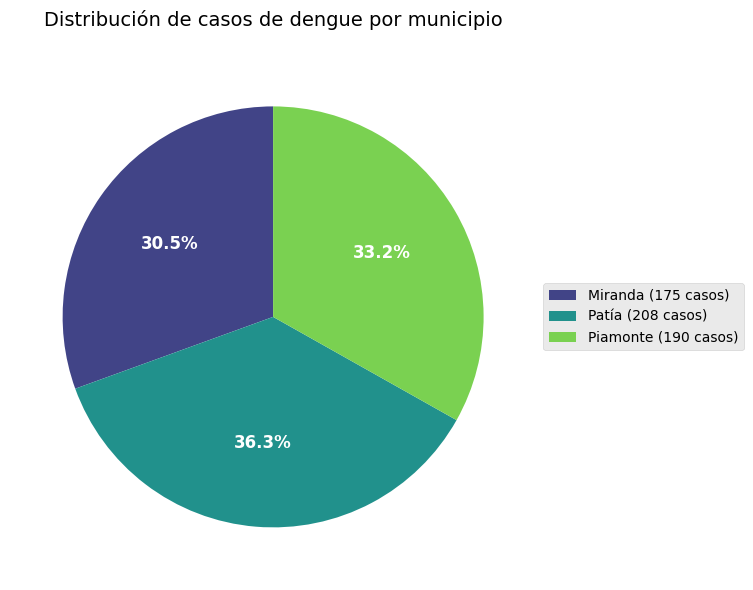

In [14]:
df_cases.rename(columns={'county': 'Barrio'}, inplace=True)

# Create a new column that represents the primary key of this dataframe
df_cases['id'] = df_cases.index

# Group data by municipality and count cases
casos_dengue_municipio = df_cases.groupby('Barrio').agg({
    'id': 'count',
}).reset_index().rename(columns={'id': 'Casos'})

# Create a pie chart
plt.figure(figsize=(10, 6))

# Define a pleasing color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(casos_dengue_municipio)))

# Create pie chart with percentages
wedges, texts, autotexts = plt.pie(
    casos_dengue_municipio['Casos'], 
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    shadow=False,
    textprops={'fontsize': 12, 'weight': 'bold', 'color': 'white'}
)

# Add legend with municipality names and case counts
legend_labels = [f"{mun} ({cases} casos)" for mun, cases in 
    zip(casos_dengue_municipio['Barrio'], casos_dengue_municipio['Casos'])]
plt.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

# Add title with better styling
plt.title('Distribución de casos de dengue por municipio', fontsize=14, pad=20)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()



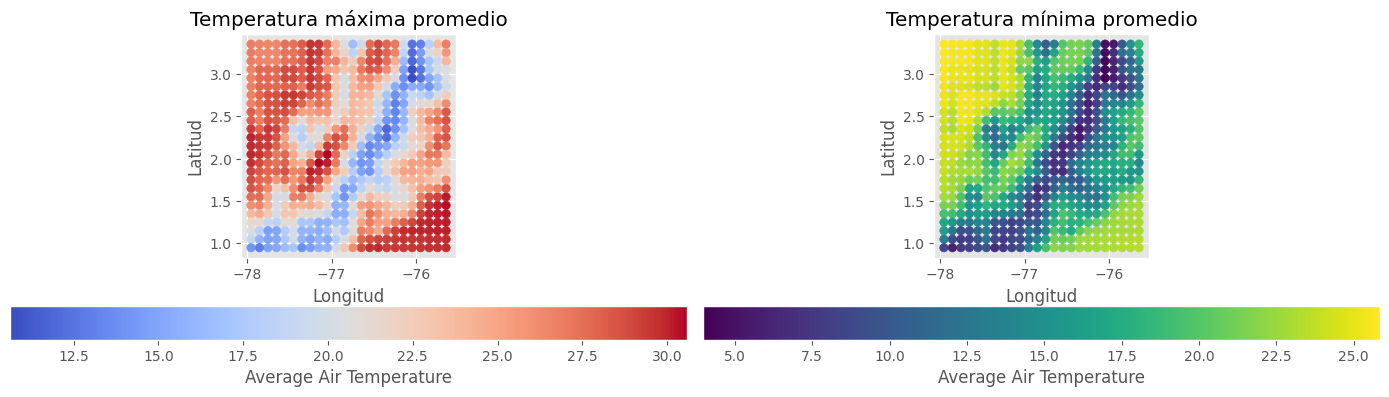

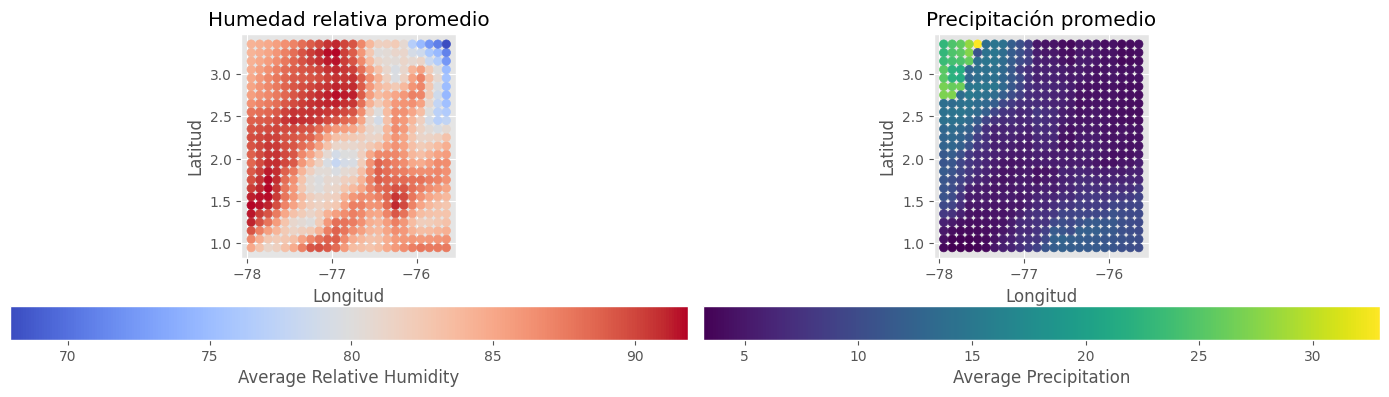

In [15]:
df_humedad_relativa_grouped = group_by_coordinates(df_humedad_relativa, 'relative_humidity')
df_precipitacion_grouped = group_by_coordinates(df_precipitacion, 'precipitation')
df_temp_max_grouped = group_by_coordinates(df_temp_max, 'air_temperature')
df_temp_min_grouped = group_by_coordinates(df_temp_min, 'air_temperature')

plot_geographic_variables(
    dataframes=[df_temp_max_grouped, df_temp_min_grouped],
    value_columns=['air_temperature', 'air_temperature'],
    titles=['Temperatura máxima promedio', 'Temperatura mínima promedio'],
    cmaps=['coolwarm', 'viridis']
)

plt.show()

plot_geographic_variables(
    dataframes=[df_humedad_relativa_grouped, df_precipitacion_grouped],
    value_columns=['relative_humidity', 'precipitation'],
    titles=['Humedad relativa promedio', 'Precipitación promedio'],
    cmaps=['coolwarm', 'viridis']
)

plt.show()

In [16]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Get location data
# df_location = df_entomologico[['county', 'decimalLatitude', 'decimalLongitude']]

# # Filter by county
# df_location_b1 = df_location[df_location['county'] == 'Patía']
# df_location_b2 = df_location[df_location['county'] == 'Miranda']
# df_location_b3 = df_location[df_location['county'] == 'Piamonte']

# # Create GeoDataFrames for each county
# gdf_patia = gpd.GeoDataFrame(df_location_b1, geometry=gpd.points_from_xy(df_location_b1.decimalLongitude, df_location_b1.decimalLatitude))
# gdf_miranda = gpd.GeoDataFrame(df_location_b2, geometry=gpd.points_from_xy(df_location_b2.decimalLongitude, df_location_b2.decimalLatitude))
# gdf_piamonte = gpd.GeoDataFrame(df_location_b3, geometry=gpd.points_from_xy(df_location_b3.decimalLongitude, df_location_b3.decimalLatitude))

# # Create first figure for Patía - wider ratio
# plt.figure(figsize=(24, 12))
# ax = gdf_patia.plot(marker='o', color='red', markersize=5, alpha=0.6)
# plt.title('Distribución en Patía', fontsize=14)
# plt.xlabel('Longitud')
# plt.ylabel('Latitud')
# plt.tight_layout()
# plt.show()

# # Create second figure for Miranda - wider ratio
# plt.figure(figsize=(16, 8))
# gdf_miranda.plot(marker='o', color='blue', markersize=5, alpha=0.6)
# plt.title('Distribución en Miranda', fontsize=14)
# plt.xlabel('Longitud')
# plt.ylabel('Latitud')
# plt.tight_layout()
# plt.show()

# # Create third figure for Piamonte - wider ratio
# plt.figure(figsize=(16, 8))
# gdf_piamonte.plot(marker='o', color='green', markersize=5, alpha=0.6)
# plt.title('Distribución en Piamonte', fontsize=14)
# plt.xlabel('Longitud')
# plt.ylabel('Latitud')
# plt.tight_layout()
# plt.show()